# étude numérique sur le "Accelerated Gradient Boosting" (AGB).

# Description des ensembles de données

Les algorithmes ont été évalués sur des ensembles de données à la fois **simulées** et **réelles**. Pour chacun des modèles simulés, nous considérons deux conceptions pour \( X = (X_1, \ldots, X_d) \):

- **Conception non corrélée** : uniforme sur \((-1, 1)^d\).
- **Conception corrélée** : gaussienne avec une moyenne de 0 et une matrice de covariance \( d \times d \), \(\Sigma\) telle que \(\Sigma_{ij} = 2^{-|i-j|}\).

Les cinq modèles suivants couvrent un large éventail de problèmes de régression et de classification. Les modèles 1-3 et 5 proviennent de Biau et al. (2016). Le modèle 4 est une légère variation d'un modèle de référence dans Hastie et al. (2009). Les modèles 1-3 sont des problèmes de **régression**, tandis que les modèles 4 et 5 sont des tâches de **classification** \(\pm 1\). Les modèles 2-4 sont additifs, tandis que les modèles 1 et 5 incluent certaines interactions. Le modèle 3 peut être considéré comme un problème clairsemé de haute dimension.

Nous notons par \( Z_{\mu,\sigma^2} \) une variable aléatoire gaussienne avec une moyenne \(\mu\) et une variance \(\sigma^2\).

**Modèle 1.** \( n = 1\,000 \), \( d = 100 \),

\[
Y = X_1 X_2 + X_3^2 - X_4 X_7 + X_8 X_{10} - X_6^2 + Z_{0,0.5}.
\]

**Modèle 2.** \( n = 800 \), \( d = 100 \),

\[
Y = -\sin(2X_1) + X_2^2 + X_3 - \exp(-X_4) + Z_{0,0.5}.
\]

**Modèle 3.** \( n = 1\,000 \), \( d = 500 \),

\[
Y = X_1 + 3X_3^2 - 2\exp(-X_5) + X_6.
\]

**Modèle 4.** \( n = 2\,000 \), \( d = 30 \),

\[
Y =
\begin{cases}
2 \cdot 1_{\sum_{j=1}^{10} X_j^2 > 3.5}-1 & \text{pour la conception non corrélée}, \\
2 \cdot 1_{\sum_{j=1}^{10} X_j^2 > 9.34}-1 & \text{pour la conception corrélée}.
\end{cases}
\]

**Modèle 5.** \( n = 1\,500 \), \( d = 50 \),

\[
Y = 2 \cdot 1_{X_1 + X_4^3 + X_9 + \sin(X_{12} X_{18}) + Z_{0,0.1} > 0.38} - 1.
\]

Nous avons également considéré les ensembles de données **réelles** suivants provenant du référentiel UCI Machine Learning : **Adult**, **Internet Advertisements**, **Communities and Crime**, **Spam**, et **Wine**. Leurs principales caractéristiques sont résumées dans le tableau ci-dessous (une description plus complète est disponible à l'adresse [https://archive.ics.uci.edu/ml/datasets.html](https://archive.ics.uci.edu/ml/datasets.html)).

| **Ensemble de données**  | \( n \)  | \( d \)  | **Sortie \( Y \)** |
|--------------------------|----------|----------|---------------------|
| Adult                    | 30 162   | 14       | binaire             |
| Advertisements           | 2 359    | 1 431    | binaire             |
| Crime                    | 1 993    | 102      | continu             |
| Spam                     | 4 601    | 57       | binaire             |
| Wine                     | 1 599    | 11       | continu             |

Pour chaque ensemble de données, simulé ou réel, l'échantillon est divisé en un ensemble d'entraînement (50%) \( D_{\text{train}} \) pour ajuster la méthode ; un ensemble de validation (25%) \( D_{\text{val}} \) pour sélectionner les hyperparamètres des algorithmes ; et un ensemble de test (25%) \( D_{\text{test}} \) sur lequel la performance prédictive est évaluée.

Nous avons considéré deux fonctions de perte pour le boosting standard et l'AGB :

- La **perte des moindres carrés** \( \psi(x, y) = (y - x)^2 \) pour la régression.
- La **perte d'Adaboost** \( \psi(x, y) = e^{-yx} \) pour la classification \(\pm 1\).


## Étape 1 : Génération et Pré-traitement des Données
Nous générons les données synthétiques pour les modèles 1 à 5, puis nous les divisons en ensembles d'entraînement, de validation, et de test

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

# Fonction pour générer des données non corrélées et corrélées
def generate_uncorrelated_data(n, d):
    return np.random.uniform(-1, 1, size=(n, d))

def generate_correlated_data(n, d):
    cov = np.array([[2**(-abs(i-j)) for j in range(d)] for i in range(d)])
    return np.random.multivariate_normal(mean=np.zeros(d), cov=cov, size=n)

# Bruit gaussien Z ~ N(µ, σ^2)
def generate_noise(mu, sigma, n):
    return np.random.normal(mu, sigma, size=n)

# Modèle 1
def generate_model_1(n, d, design='uncorrelated'):
    X = generate_uncorrelated_data(n, d) if design == 'uncorrelated' else generate_correlated_data(n, d)
    Y = X[:, 0] * X[:, 1] + X[:, 2]**2 - X[:, 3] * X[:, 6] + X[:, 7] * X[:, 9] - X[:, 5]**2 + generate_noise(0, 0.5, n)
    return X, Y

# Modèle 2
def generate_model_2(n, d, design='uncorrelated'):
    X = generate_uncorrelated_data(n, d) if design == 'uncorrelated' else generate_correlated_data(n, d)
    Y = -np.sin(2 * X[:, 0]) + X[:, 1]**2 + X[:, 2] - np.exp(-X[:, 3]) + generate_noise(0, 0.5, n)
    return X, Y

# Modèle 3
def generate_model_3(n, d, design='uncorrelated'):
    X = generate_uncorrelated_data(n, d) if design == 'uncorrelated' else generate_correlated_data(n, d)
    Y = X[:, 0] + 3 * X[:, 2]**2 - 2 * np.exp(-X[:, 4]) + X[:, 5]
    return X, Y

# Modèle 4
def generate_model_4(n, d, design='uncorrelated'):
    X = generate_uncorrelated_data(n, d)
    threshold = 3.5 if design == 'uncorrelated' else 9.34
    Y = 2 * (np.sum(X[:, :10]**2, axis=1) > threshold) - 1
    return X, Y

# Modèle 5
def generate_model_5(n, d, design='uncorrelated'):
    X = generate_uncorrelated_data(n, d)
    try:
        Y = 2 * ((X[:, 0] + X[:, 3]**3 + X[:, 8] + np.sin(X[:, 11] * X[:, 17]) + generate_noise(0, 0.1, n)) > 0.38) - 1
    except IndexError:
        Y = np.zeros(n)
    return X, Y

# Fonction pour diviser les données en ensembles d'entraînement, de validation, et de test
def split_data(X, Y):
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.5, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, Y_train, Y_val, Y_test


# Génération des données pour chaque modèle
def generate_all_data():
    n_samples = {
        'model_1': 1000, 'model_2': 800, 'model_3': 1000, 
        'model_4': 2000, 'model_5': 1500
    }
    d_dimensions = {
        'model_1': 100, 'model_2': 100, 'model_3': 500, 
        'model_4': 30, 'model_5': 50
    }

    dataframes = {}
    # Génération des datasets
    for model, (n, d) in zip(['model_1', 'model_2', 'model_3', 'model_4', 'model_5'], zip(n_samples.values(), d_dimensions.values())):
        generator = globals()[f'generate_{model}']
        X, Y = generator(n, d, design='uncorrelated')  # Génération des données non corrélées
        df = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(d)])
        df['Y'] = Y
        dataframes[model] = df
    
    return dataframes

# Générer les données pour tous les modèles
dataframes = generate_all_data()



In [6]:
# Afficher le DataFrame pour un modèle spécifique
def afficher_modele_specifique(nom_modele):
    # Vérifier si le modèle demandé existe dans les données générées
    if nom_modele in dataframes:
        df = dataframes[nom_modele]
        print(f"Données du {nom_modele}:")
        print(df.head())  # Affiche les premières lignes du DataFrame
    else:
        # Message d'erreur si le modèle n'existe pas
        print(f"Le modèle {nom_modele} n'existe pas.")


In [22]:
# Exemple d'utilisation pour afficher les données du 'model_1'
afficher_modele_specifique('model_4')


Données du model_4:
         X1        X2        X3        X4        X5        X6        X7  \
0  0.297165 -0.672123  0.509169  0.995828 -0.641243 -0.247843  0.809716   
1  0.691902  0.084003  0.567605  0.544212 -0.598188  0.997738 -0.324403   
2  0.115075  0.305558 -0.829125  0.731391 -0.934156 -0.458457  0.243452   
3  0.160904  0.110152 -0.130198  0.448292 -0.222450  0.091436  0.116915   
4  0.776007  0.726625 -0.175297  0.549623 -0.641786 -0.217677 -0.090656   

         X8        X9       X10  ...       X22       X23       X24       X25  \
0 -0.022985 -0.095064  0.685198  ...  0.983831  0.086578  0.149071 -0.940561   
1  0.331991  0.475542  0.791758  ...  0.740879 -0.944041  0.171329  0.399717   
2 -0.114046 -0.331985 -0.916379  ... -0.895804  0.269964  0.118051 -0.287923   
3 -0.998243  0.094658 -0.907255  ...  0.689942 -0.640407  0.628875 -0.751099   
4  0.399585  0.222427  0.600565  ...  0.089304 -0.863827  0.225355 -0.978750   

        X26       X27       X28       X29       

# Etape 2 Implementaion 

## Accelerated Gradient Boosting (AGB)

In [25]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Définir la fonction Accelerated Gradient Boosting (AGB)
def agb(formula, data, nesterov=True, train_fraction=0.75, n_trees=100, shrinkage=0.01, 
        new_data=None, distribution="gaussian", depth_tree=1, n_minobsinnode=10):
    
    # Diviser les données en train et validation
    n = data.shape[0]
    np.random.seed(12345)
    perm = np.random.permutation(n)
    n_train = round(n * train_fraction)
    n_valid = n - n_train
    train = data.iloc[perm[:n_train]]
    valid = data.iloc[perm[n_train:]]
    
    # Exclure la colonne cible pour l'entraînement
    train_X = train.iloc[:, 1:]  # Utiliser seulement les caractéristiques
    valid_X = valid.iloc[:, 1:]  # Utiliser seulement les caractéristiques

    if new_data is None:
        new_data = data.iloc[:, 1:]  # Exclure la première colonne (la cible) pour les nouvelles données
    else:
        new_data = new_data.iloc[:, :]  # Assurez-vous que new_data contient les mêmes colonnes que X_train

    # Initialiser les prédictions
    fitted = np.zeros((n_train, n_trees))
    prev_valid = np.zeros((n_valid, n_trees))
    prev_new = np.zeros((new_data.shape[0], n_trees))
    
    # Initialiser des vecteurs pour accélération de Nesterov
    g_fitted = np.copy(fitted)
    g_prev_valid = np.copy(prev_valid)
    g_prev_new = np.copy(prev_new)
    
    # Initialiser les erreurs
    err_train = np.zeros(n_trees)
    err_valid = np.zeros(n_trees)
    err_new = np.zeros(n_trees)
    
    # Gestion des distributions
    if distribution == "gaussian":
        fitted[:, 0] = train.iloc[:, 0].mean()
        prev_valid[:, 0] = train.iloc[:, 0].mean()
        prev_new[:, 0] = train.iloc[:, 0].mean()
        g_fitted[:, 0] = fitted[:, 0]
        g_prev_valid[:, 0] = prev_valid[:, 0]
        g_prev_new[:, 0] = prev_new[:, 0]
        
        err_train[0] = np.mean((train.iloc[:, 0] - fitted[:, 0]) ** 2)
        err_valid[0] = np.mean((valid.iloc[:, 0] - prev_valid[:, 0]) ** 2)
        err_new[0] = np.mean((new_data.iloc[:, 0] - prev_new[:, 0]) ** 2)

    elif distribution == "adaboost":
        fitted[:, 0] = 0.5 * np.log(np.sum(train.iloc[:, 0]) / np.sum(1 - train.iloc[:, 0]))
        prev_valid[:, 0] = fitted[0, 0]
        prev_new[:, 0] = fitted[0, 0]
        g_fitted[:, 0] = fitted[:, 0]
        g_prev_valid[:, 0] = prev_valid[:, 0]
        g_prev_new[:, 0] = prev_new[:, 0]
        
        err_train[0] = np.mean(np.exp(-(2 * train.iloc[:, 0] - 1) * fitted[:, 0]))
        err_valid[0] = np.mean(np.exp(-(2 * valid.iloc[:, 0] - 1) * prev_valid[:, 0]))
        err_new[0] = np.mean(np.exp(-(2 * new_data.iloc[:, 0] - 1) * prev_new[:, 0]))

    elif distribution == "bernoulli":
        fitted[:, 0] = np.log(np.mean(train.iloc[:, 0]) / np.mean(1 - train.iloc[:, 0]))
        prev_valid[:, 0] = fitted[0, 0]
        prev_new[:, 0] = fitted[0, 0]
        g_fitted[:, 0] = fitted[:, 0]
        g_prev_valid[:, 0] = prev_valid[:, 0]
        g_prev_new[:, 0] = prev_new[:, 0]
        
        err_train[0] = -2 * np.mean(train.iloc[:, 0] * fitted[:, 0] - np.log(1 + np.exp(fitted[:, 0])))
        err_valid[0] = -2 * np.mean(valid.iloc[:, 0] * prev_valid[:, 0] - np.log(1 + np.exp(prev_valid[:, 0])))
        err_new[0] = -2 * np.mean(new_data.iloc[:, 0] * prev_new[:, 0] - np.log(1 + np.exp(prev_new[:, 0])))

    # Lambda et gamma pour Nesterov
    lambda_vals = np.ones(n_trees)
    gamma_vals = np.ones(n_trees)
    for i in range(1, n_trees):
        lambda_vals[i] = 0.5 * (1 + np.sqrt(1 + 4 * lambda_vals[i-1]**2))
    
    # Boucle de boosting
    for i in range(1, n_trees):
        if distribution == "gaussian":
            if nesterov:
                if i < n_trees - 1:  # Pour éviter d'accéder à lambda_vals[i + 1] à la dernière itération
                    gamma_vals[i] = (1 - lambda_vals[i]) / lambda_vals[i + 1]
                U = train.iloc[:, 0] - g_fitted[:, i - 1]
                tree = DecisionTreeRegressor(max_depth=depth_tree, min_samples_leaf=n_minobsinnode)
                
                # Entraînement sur train_X (caractéristiques seulement)
                tree.fit(train_X, U)
                
                # Prédictions sur les caractéristiques (valid_X, new_data)
                fitted[:, i] = g_fitted[:, i - 1] + shrinkage * tree.predict(train_X)
                prev_valid[:, i] = g_prev_valid[:, i - 1] + shrinkage * tree.predict(valid_X)
                prev_new[:, i] = g_prev_new[:, i - 1] + shrinkage * tree.predict(new_data)
                
                g_fitted[:, i] = (1 - gamma_vals[i - 1]) * fitted[:, i] + gamma_vals[i - 1] * fitted[:, i - 1]
                g_prev_valid[:, i] = (1 - gamma_vals[i - 1]) * prev_valid[:, i] + gamma_vals[i - 1] * prev_valid[:, i - 1]
                g_prev_new[:, i] = (1 - gamma_vals[i - 1]) * prev_new[:, i] + gamma_vals[i - 1] * prev_new[:, i - 1]
            else:
                U = train.iloc[:, 0] - fitted[:, i - 1]
                tree = DecisionTreeRegressor(max_depth=depth_tree, min_samples_leaf=n_minobsinnode)
                tree.fit(train_X, U)
                fitted[:, i] = fitted[:, i - 1] + shrinkage * tree.predict(train_X)
                prev_valid[:, i] = prev_valid[:, i - 1] + shrinkage * tree.predict(valid_X)
                prev_new[:, i] = prev_new[:, i - 1] + shrinkage * tree.predict(new_data)

        elif distribution == "adaboost":
            if nesterov:
                gamma_vals[i] = (1 - lambda_vals[i]) / lambda_vals[i + 1]
                U = -(2 * train.iloc[:, 0] - 1) * np.exp(-(2 * train.iloc[:, 0] - 1) * g_fitted[:, i - 1])
                tree = DecisionTreeRegressor(max_depth=depth_tree, min_samples_leaf=n_minobsinnode)
                tree.fit(train_X, U)
                fitted[:, i] = g_fitted[:, i - 1] + shrinkage * tree.predict(train_X)
                prev_valid[:, i] = g_prev_valid[:, i - 1] + shrinkage * tree.predict(valid_X)
                prev_new[:, i] = g_prev_new[:, i - 1] + shrinkage * tree.predict(new_data)
                g_fitted[:, i] = (1 - gamma_vals[i - 1]) * fitted[:, i] + gamma_vals[i - 1] * fitted[:, i - 1]
                g_prev_valid[:, i] = (1 - gamma_vals[i - 1]) * prev_valid[:, i] + gamma_vals[i - 1] * prev_valid[:, i - 1]
                g_prev_new[:, i] = (1 - gamma_vals[i - 1]) * prev_new[:, i] + gamma_vals[i - 1] * prev_new[:, i - 1]

        elif distribution == "bernoulli":
            if nesterov:
                gamma_vals[i] = (1 - lambda_vals[i]) / lambda_vals[i + 1]
                p_fitted = 1 / (1 + np.exp(-g_fitted[:, i - 1]))
                U = train.iloc[:, 0] - p_fitted
                tree = DecisionTreeRegressor(max_depth=depth_tree, min_samples_leaf=n_minobsinnode)
                tree.fit(train_X, U)
                fitted[:, i] = g_fitted[:, i - 1] + shrinkage * tree.predict(train_X)
                prev_valid[:, i] = g_prev_valid[:, i - 1] + shrinkage * tree.predict(valid_X)
                prev_new[:, i] = g_prev_new[:, i - 1] + shrinkage * tree.predict(new_data)
                g_fitted[:, i] = (1 - gamma_vals[i - 1]) * fitted[:, i] + gamma_vals[i - 1] * fitted[:, i - 1]
                g_prev_valid[:, i] = (1 - gamma_vals[i - 1]) * prev_valid[:, i] + gamma_vals[i - 1] * prev_valid[:, i - 1]
                g_prev_new[:, i] = (1 - gamma_vals[i - 1]) * prev_new[:, i] + gamma_vals[i - 1] * prev_new[:, i - 1]

        # Calcul des erreurs
        if distribution == "gaussian":
            err_train[i] = np.mean((train.iloc[:, 0] - fitted[:, i]) ** 2)
            err_valid[i] = np.mean((valid.iloc[:, 0] - prev_valid[:, i]) ** 2)
            err_new[i] = np.mean((new_data.iloc[:, 0] - prev_new[:, i]) ** 2)
        elif distribution == "adaboost":
            err_train[i] = np.mean(np.exp(-(2 * train.iloc[:, 0] - 1) * fitted[:, i]))
            err_valid[i] = np.mean(np.exp(-(2 * valid.iloc[:, 0] - 1) * prev_valid[:, i]))
            err_new[i] = np.mean(np.exp(-(2 * new_data.iloc[:, 0] - 1) * prev_new[:, i]))
        elif distribution == "bernoulli":
            err_train[i] = -2 * np.mean(train.iloc[:, 0] * fitted[:, i] - np.log(1 + np.exp(fitted[:, i])))
            err_valid[i] = -2 * np.mean(valid.iloc[:, 0] * prev_valid[:, i] - np.log(1 + np.exp(prev_valid[:, i])))
            err_new[i] = -2 * np.mean(new_data.iloc[:, 0] * prev_new[:, i] - np.log(1 + np.exp(prev_new[:, i])))

        # Condition d'arrêt
        if err_valid[i] >= 100:
            n_trees = i
            err_train = err_train[:i]
            err_valid = err_valid[:i]
            err_new = err_new[:i]
            prev_new = prev_new[:, :i]
            break

    
    return {
        "best_iteration": np.argmin(err_valid),
        "train_error": err_train,
        "valid_error": err_valid,
        "new_error": err_new,
        "predictions_new": prev_new
}


# Courbe d'erreur en fonction du nombre d'arbre

Évaluation du modèle : model_1


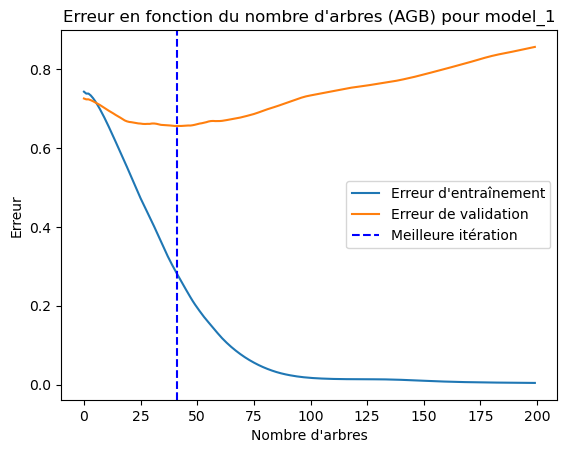

In [12]:
# Fonction pour choisir un modèle et l'évaluer avec AGB
def evaluate_agb_on_specific_model(dataframes, model_name, n_trees=200, shrinkage=0.01, depth_tree=3, n_minobsinnode=5):
    if model_name not in dataframes:
        print(f"Modèle {model_name} non disponible.")
        return

    print(f"Évaluation du modèle : {model_name}")
    
    # Extraire les données du modèle sélectionné
    df = dataframes[model_name]
    
    # Diviser les données
    X = df.drop(columns=['Y'])
    Y = df['Y']
    X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

    # Créer des DataFrames pour chaque ensemble
    train_data = pd.concat([pd.DataFrame(Y_train, columns=["Y"]), pd.DataFrame(X_train)], axis=1)
    val_data = pd.concat([pd.DataFrame(Y_val, columns=["Y"]), pd.DataFrame(X_val)], axis=1)
    test_data = pd.concat([pd.DataFrame(Y_test, columns=["Y"]), pd.DataFrame(X_test)], axis=1)

    # Appel de la fonction AGB
    result = agb(
        formula="Y ~ .", data=train_data, nesterov=True, n_trees=n_trees, shrinkage=shrinkage,
        new_data=test_data.drop(columns=["Y"]), distribution="gaussian" if model_name in ['model_1', 'model_2', 'model_3'] else "adaboost",
        depth_tree=depth_tree, n_minobsinnode=n_minobsinnode
    )

    # Visualisation des erreurs d'entraînement et de validation
    plt.plot(result['train_error'], label='Erreur d\'entraînement')
    plt.plot(result['valid_error'], label='Erreur de validation')
    plt.axvline(x=result['best_iteration'], color='blue', linestyle='--', label="Meilleure itération")
    plt.xlabel('Nombre d\'arbres')
    plt.ylabel('Erreur')
    plt.legend()
    plt.title(f'Erreur en fonction du nombre d\'arbres (AGB) pour {model_name}')
    plt.show()

    return result

# Exemple : L'utilisateur choisit d'évaluer le modèle 1
selected_model = "model_1"  # Choisissez entre 'model_1', 'model_2', 'model_3', 'model_4', 'model_5'
result = evaluate_agb_on_specific_model(dataframes, selected_model, n_trees=200, shrinkage=0.01, depth_tree=3, n_minobsinnode=5)


# Courbe d'erreur en fonction dU paramètre de rétrécissement

Évaluation du modèle : model_1
Evaluation avec shrinkage = 1e-05
Evaluation avec shrinkage = 0.001
Evaluation avec shrinkage = 0.01
Evaluation avec shrinkage = 0.1
Evaluation avec shrinkage = 0.5


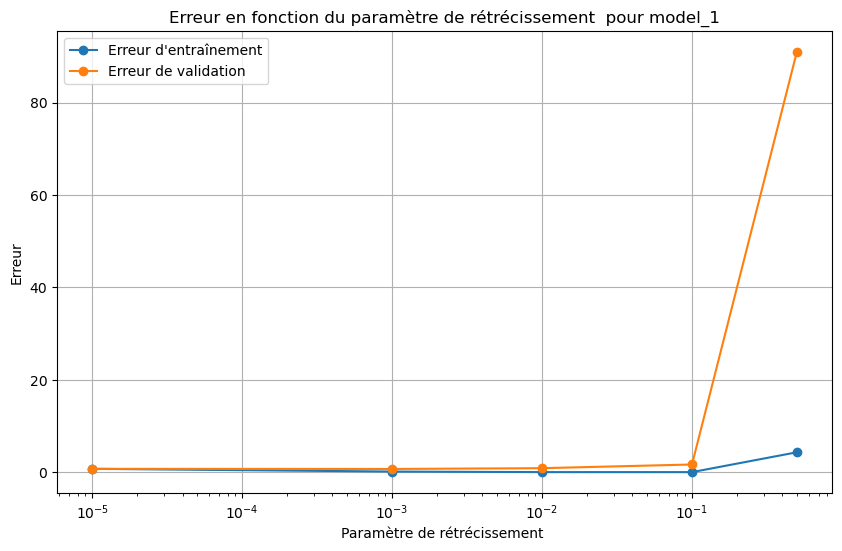

In [14]:
import matplotlib.pyplot as plt

# Ajuster la fonction pour évaluer l'AGB en fonction de plusieurs valeurs de \(\nu\)
def evaluate_agb_on_shrinkage(dataframes, model_name, shrinkage_values=[1e-5, 0.001, 0.01, 0.1, 0.5], n_trees=200, depth_tree=3, n_minobsinnode=5):
    if model_name not in dataframes:
        print(f"Modèle {model_name} non disponible.")
        return

    print(f"Évaluation du modèle : {model_name}")
    
    # Extraire les données du modèle sélectionné
    df = dataframes[model_name]
    
    # Diviser les données
    X = df.drop(columns=['Y'])
    Y = df['Y']
    X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

    # Créer des DataFrames pour chaque ensemble
    train_data = pd.concat([pd.DataFrame(Y_train, columns=["Y"]), pd.DataFrame(X_train)], axis=1)
    val_data = pd.concat([pd.DataFrame(Y_val, columns=["Y"]), pd.DataFrame(X_val)], axis=1)
    test_data = pd.concat([pd.DataFrame(Y_test, columns=["Y"]), pd.DataFrame(X_test)], axis=1)

    # Stocker les résultats pour chaque valeur de \(\nu\)
    errors = {
        "train_errors": [],
        "valid_errors": [],
        "new_errors": [],
        "shrinkage_values": shrinkage_values
    }

    # Exécuter AGB pour chaque valeur de \(\nu\)
    for shrinkage in shrinkage_values:
        print(f"Evaluation avec shrinkage = {shrinkage}")
        result = agb(
            formula="Y ~ .", data=train_data, nesterov=True, n_trees=n_trees, shrinkage=shrinkage,
            new_data=test_data.drop(columns=["Y"]), distribution="gaussian" if model_name in ['model_1', 'model_2', 'model_3'] else "adaboost",
            depth_tree=depth_tree, n_minobsinnode=n_minobsinnode
        )

        # Stocker les erreurs pour cette valeur de \(\nu\)
        errors["train_errors"].append(result['train_error'][-1])  # Erreur finale
        errors["valid_errors"].append(result['valid_error'][-1])  # Erreur finale
        errors["new_errors"].append(result['new_error'][-1])      # Erreur sur les nouvelles données

    # Tracer les courbes en fonction de \(\nu\)
    plt.figure(figsize=(10, 6))
    plt.plot(errors["shrinkage_values"], errors["train_errors"], label="Erreur d'entraînement", marker='o')
    plt.plot(errors["shrinkage_values"], errors["valid_errors"], label="Erreur de validation", marker='o')
    plt.xscale('log')  # Utilisation d'une échelle logarithmique pour \(\nu\)
    plt.xlabel('Paramètre de rétrécissement ')
    plt.ylabel('Erreur')
    plt.legend()
    plt.title(f'Erreur en fonction du paramètre de rétrécissement  pour {model_name}')
    plt.grid(True)
    plt.show()

    return errors

# Exemple : L'utilisateur choisit d'évaluer le modèle 1 en fonction de \(\nu\)
selected_model = "model_1"  # Choisissez entre 'model_1', 'model_2', 'model_3', 'model_4', 'model_5'
shrinkage_values = [1e-5, 0.001, 0.01, 0.1, 0.5]
errors = evaluate_agb_on_shrinkage(dataframes, selected_model, shrinkage_values, n_trees=200, depth_tree=3, n_minobsinnode=5)


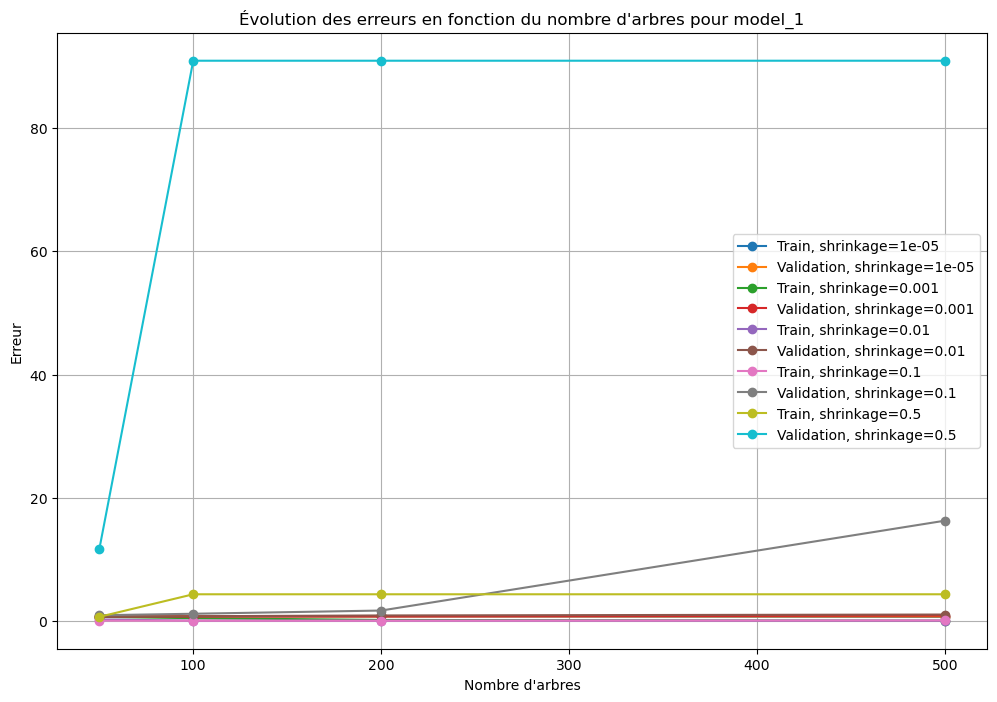

In [18]:
import matplotlib.pyplot as plt

# Ajuster la fonction pour évaluer l'AGB en fonction de plusieurs valeurs de \(\nu\) et du nombre d'arbres
def evaluate_agb_shrinkage_and_trees(dataframes, model_name, shrinkage_values=[1e-5, 0.001, 0.01, 0.1, 0.5], 
                                     tree_values=[50, 100, 200, 500], depth_tree=3, n_minobsinnode=5, save_path=None):
    if model_name not in dataframes:
        print(f"Modèle {model_name} non disponible.")
        return

    # Extraire les données du modèle sélectionné
    df = dataframes[model_name]
    
    # Diviser les données
    X = df.drop(columns=['Y'])
    Y = df['Y']
    X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

    # Créer des DataFrames pour chaque ensemble
    train_data = pd.concat([pd.DataFrame(Y_train, columns=["Y"]), pd.DataFrame(X_train)], axis=1)
    val_data = pd.concat([pd.DataFrame(Y_val, columns=["Y"]), pd.DataFrame(X_val)], axis=1)
    test_data = pd.concat([pd.DataFrame(Y_test, columns=["Y"]), pd.DataFrame(X_test)], axis=1)

    # Stocker les résultats pour chaque combinaison de \(\nu\) et \(n\_trees\)
    results = {}

    # Exécuter AGB pour chaque valeur de \(\nu\) et de \(n\_trees\)
    for shrinkage in shrinkage_values:
        results[shrinkage] = {
            "train_errors": [],
            "valid_errors": [],
            "new_errors": [],
            "n_trees": tree_values
        }
        for n_trees in tree_values:
            result = agb(
                formula="Y ~ .", data=train_data, nesterov=True, n_trees=n_trees, shrinkage=shrinkage,
                new_data=test_data.drop(columns=["Y"]), distribution="gaussian" if model_name in ['model_1', 'model_2', 'model_3'] else "adaboost",
                depth_tree=depth_tree, n_minobsinnode=n_minobsinnode
            )

            # Stocker les erreurs pour cette valeur de \(\nu\) et \(n\_trees\)
            results[shrinkage]["train_errors"].append(result['train_error'][-1])  # Erreur finale
            results[shrinkage]["valid_errors"].append(result['valid_error'][-1])  # Erreur finale
            results[shrinkage]["new_errors"].append(result['new_error'][-1])      # Erreur sur les nouvelles données

    # Tracer les courbes en fonction de \(n\_trees\) pour chaque \(\nu\)
    plt.figure(figsize=(12, 8))
    
    for shrinkage in shrinkage_values:
        plt.plot(results[shrinkage]["n_trees"], results[shrinkage]["train_errors"], label=f"Train, shrinkage={shrinkage}", marker='o')
        plt.plot(results[shrinkage]["n_trees"], results[shrinkage]["valid_errors"], label=f"Validation, shrinkage={shrinkage}", marker='o')

    plt.xlabel('Nombre d\'arbres')
    plt.ylabel('Erreur')
    plt.legend()
    plt.title(f'Évolution des erreurs en fonction du nombre d\'arbres pour {model_name}')
    plt.grid(True)

    # Enregistrer le graphique si le chemin est fourni
    #if save_path:
        #plt.savefig(save_path)
       # print(f"Graphique sauvegardé sous : {save_path}")
    
    # Afficher le graphique
    plt.show()

    return results

# Exemple : L'utilisateur choisit d'évaluer le modèle 1 en fonction de \(\nu\) et du nombre d'arbres, et de sauvegarder le graphique
selected_model = "model_1"  # Choisissez entre 'model_1', 'model_2', 'model_3', 'model_4', 'model_5'
shrinkage_values = [1e-5, 0.001, 0.01, 0.1, 0.5]
tree_values = [50, 100, 200, 500]  # Différents nombres d'arbres

# Spécifier le chemin de sauvegarde
#save_path = "evaluation_model_1_shrinkage_vs_trees.png"

# Appeler la fonction et sauvegarder le graphique
results = evaluate_agb_shrinkage_and_trees(dataframes, selected_model, shrinkage_values, tree_values, depth_tree=3, n_minobsinnode=5)#, save_path=save_path)


## Les forets aleatoires

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, accuracy_score

# Fonction pour entraîner et évaluer chaque méthode sur les modèles
def compare_models_on_data(dataframes, n_trees=2500, shrinkage=0.1, depth_tree=3, n_minobsinnode=5):
    model_names = list(dataframes.keys())
    mse_agb_list = []
    mse_boosting_standard_list = []
    mse_lasso_list = []
    mse_rf_list = []
    
    for model_name in model_names:
        print(f"Évaluation sur le modèle : {model_name}")
        df = dataframes[model_name]
        
        # Vérifier et éliminer les lignes avec des NaN dans les cibles (Y)
        df = df.dropna(subset=['Y'])

        # Diviser les données
        X = df.drop(columns=['Y'])
        Y = df['Y']

        # Pour les modèles 4 et 5, s'assurer que Y est binaire (-1 ou 1)
        if model_name in ['model_4', 'model_5']:
            Y = np.where(Y > 0, 1, -1)  # Assurez-vous que les cibles sont -1 ou 1
        
        # Vérifier et éliminer les lignes avec des NaN dans les prédicteurs (X)
        X = X.dropna()

        # Diviser les données en ensembles d'entraînement, validation et test
        X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

        # Pour les modèles 1, 2 et 3 (régression)
        if model_name in ['model_1', 'model_2', 'model_3']:
            # Modèle 1 : AGB avec Nesterov (régression)
            result_agb = agb(
                formula="Y ~ .", data=pd.concat([pd.DataFrame(Y_train, columns=["Y"]), pd.DataFrame(X_train)], axis=1),
                nesterov=True, n_trees=n_trees, shrinkage=shrinkage,
                new_data=pd.DataFrame(X_test), distribution="gaussian",
                depth_tree=depth_tree, n_minobsinnode=n_minobsinnode
            )
            mse_agb = mean_squared_error(Y_test, result_agb['predictions_new'][:, -1])
            mse_agb_list.append(mse_agb)

            # Modèle 2 : Boosting Standard (régression)
            gbr = GradientBoostingRegressor(n_estimators=n_trees, learning_rate=shrinkage, max_depth=depth_tree)
            gbr.fit(X_train, Y_train)
            pred_boosting_standard = gbr.predict(X_test)
            mse_boosting_standard = mean_squared_error(Y_test, pred_boosting_standard)
            mse_boosting_standard_list.append(mse_boosting_standard)

            # Modèle 3 : Lasso (régression)
            lasso = LassoCV(cv=5)
            lasso.fit(X_train, Y_train)
            pred_lasso = lasso.predict(X_test)
            mse_lasso = mean_squared_error(Y_test, pred_lasso)
            mse_lasso_list.append(mse_lasso)

            # Modèle 4 : Forêts Aléatoires (régression)
            rf = RandomForestRegressor(n_estimators=n_trees, max_depth=depth_tree, random_state=42)
            rf.fit(X_train, Y_train)
            pred_rf = rf.predict(X_test)
            mse_rf = mean_squared_error(Y_test, pred_rf)
            mse_rf_list.append(mse_rf)

        # Pour les modèles 4 et 5 (classification)
        else:
            # Modèle 1 : AGB avec Nesterov (classification)
            result_agb = agb(
                formula="Y ~ .", data=pd.concat([pd.DataFrame(Y_train, columns=["Y"]), pd.DataFrame(X_train)], axis=1),
                nesterov=True, n_trees=n_trees, shrinkage=shrinkage,
                new_data=pd.DataFrame(X_test), distribution="adaboost",
                depth_tree=depth_tree, n_minobsinnode=n_minobsinnode
            )
            pred_agb_class = np.sign(result_agb['predictions_new'][:, -1])  # Prédiction en classification (sign)
            error_agb = 1 - accuracy_score(Y_test, pred_agb_class)
            mse_agb_list.append(error_agb)

            # Modèle 2 : Boosting Standard (classification)
            gbc = GradientBoostingClassifier(n_estimators=n_trees, learning_rate=shrinkage, max_depth=depth_tree)
            gbc.fit(X_train, Y_train)
            pred_boosting_standard = gbc.predict(X_test)
            error_boosting_standard = 1 - accuracy_score(Y_test, pred_boosting_standard)
            mse_boosting_standard_list.append(error_boosting_standard)

            # Modèle 3 : Lasso (classification)
            logreg = LogisticRegressionCV(cv=5, max_iter=1000)
            logreg.fit(X_train, Y_train)
            pred_lasso_class = logreg.predict(X_test)
            error_lasso = 1 - accuracy_score(Y_test, pred_lasso_class)
            mse_lasso_list.append(error_lasso)

            # Modèle 4 : Forêts Aléatoires (classification)
            rf_class = RandomForestClassifier(n_estimators=n_trees, max_depth=depth_tree, random_state=42)
            rf_class.fit(X_train, Y_train)
            pred_rf_class = rf_class.predict(X_test)
            error_rf = 1 - accuracy_score(Y_test, pred_rf_class)
            mse_rf_list.append(error_rf)
    
    return model_names, mse_agb_list, mse_boosting_standard_list, mse_lasso_list, mse_rf_list

# Fonction pour afficher les résultats sous forme de barres
def plot_mse_comparison(model_names, mse_agb, mse_boosting_standard, mse_lasso, mse_rf):
    bar_width = 0.2
    index = np.arange(len(model_names))

    plt.figure(figsize=(10, 6))

    # Bar positions for each method
    plt.bar(index, mse_agb, bar_width, label="AGB")
    plt.bar(index + bar_width, mse_boosting_standard, bar_width, label="Boosting Standard (GBR/GBC)")
    plt.bar(index + 2 * bar_width, mse_lasso, bar_width, label="Lasso/Logistic Regression")
    plt.bar(index + 3 * bar_width, mse_rf, bar_width, label="Forêts Aléatoires")

    # Labels and legends
    plt.xlabel('Modèles')
    plt.ylabel('MSE / Erreur de classification')
    plt.title('Comparaison des MSE/erreurs entre AGB, Boosting Standard, Lasso et Forêts Aléatoires')
    plt.xticks(index + bar_width, model_names)
    plt.legend()
    plt.tight_layout()

    # Afficher le graphique
    plt.show()

# Utilisation des fonctions pour comparer et visualiser les MSE ou taux d'erreur
model_names, mse_agb, mse_boosting_standard, mse_lasso, mse_rf = compare_models_on_data(dataframes, n_trees=2500, shrinkage=0.1, depth_tree=3, n_minobsinnode=5)

# Afficher le graphique comparatif des MSE et erreurs de classification
plot_mse_comparison(model_names, mse_agb, mse_boosting_standard, mse_lasso, mse_rf)


Évaluation sur le modèle : model_1
Évaluation sur le modèle : model_2
Évaluation sur le modèle : model_3
Évaluation sur le modèle : model_4


C:\Users\Lass\AppData\Local\Temp\ipykernel_7740\105647728.py:57: RuntimeWarning: invalid value encountered in log
  fitted[:, 0] = 0.5 * np.log(np.sum(train.iloc[:, 0]) / np.sum(1 - train.iloc[:, 0]))


ValueError: Input y contains NaN.

## Le lasso

Évaluation sur le modèle : model_1
Évaluation sur le modèle : model_2
Évaluation sur le modèle : model_3


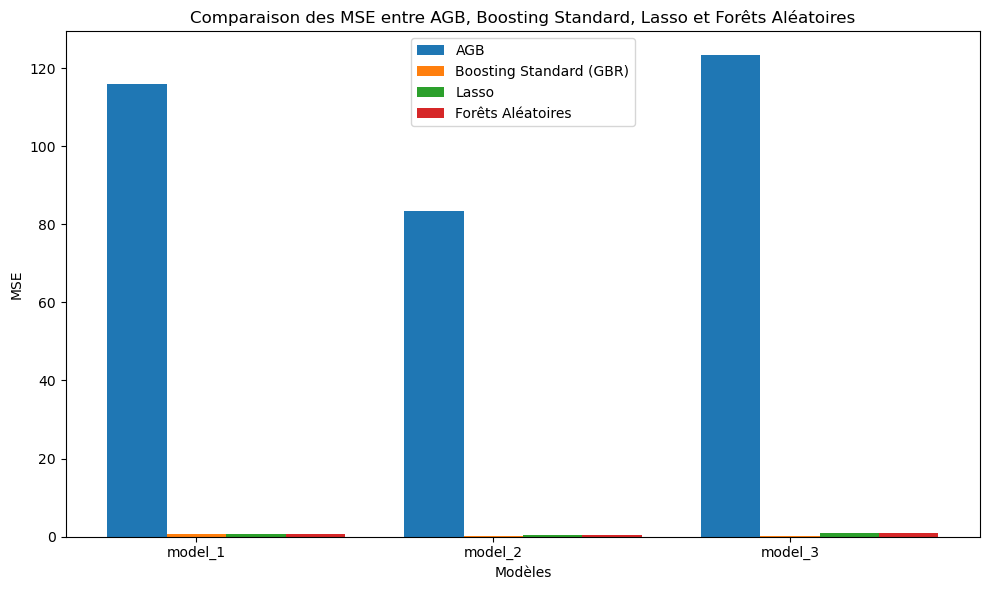

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

# Fonction pour entraîner et évaluer chaque méthode sur les modèles
def compare_models_on_data(dataframes, n_trees=2500, shrinkage=0.1, depth_tree=2, n_minobsinnode=5):
    model_names = ['model_1', 'model_2', 'model_3']  # Only regression models
    mse_agb_list = []
    mse_boosting_standard_list = []
    mse_lasso_list = []
    mse_rf_list = []
    
    for model_name in model_names:
        print(f"Évaluation sur le modèle : {model_name}")
        df = dataframes[model_name]
        
        # Vérifier et éliminer les lignes avec des NaN dans les cibles (Y)
        df = df.dropna(subset=['Y'])

        # Diviser les données
        X = df.drop(columns=['Y'])
        Y = df['Y']

        # Vérifier et éliminer les lignes avec des NaN dans les prédicteurs (X)
        X = X.dropna()

        # Diviser les données en ensembles d'entraînement, validation et test
        X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

        # Modèle 1 : AGB avec Nesterov (régression)
        result_agb = agb(
            formula="Y ~ .", data=pd.concat([pd.DataFrame(Y_train, columns=["Y"]), pd.DataFrame(X_train)], axis=1),
            nesterov=True, n_trees=n_trees, shrinkage=shrinkage,
            new_data=pd.DataFrame(X_test), distribution="gaussian",
            depth_tree=depth_tree, n_minobsinnode=n_minobsinnode
        )
        mse_agb = mean_squared_error(Y_test, result_agb['predictions_new'][:, -1])
        mse_agb_list.append(mse_agb)

        # Modèle 2 : Boosting Standard (régression)
        gbr = GradientBoostingRegressor(n_estimators=n_trees, learning_rate=shrinkage, max_depth=depth_tree)
        gbr.fit(X_train, Y_train)
        pred_boosting_standard = gbr.predict(X_test)
        mse_boosting_standard = mean_squared_error(Y_test, pred_boosting_standard)
        mse_boosting_standard_list.append(mse_boosting_standard)

        # Modèle 3 : Lasso (régression)
        lasso = LassoCV(cv=5)
        lasso.fit(X_train, Y_train)
        pred_lasso = lasso.predict(X_test)
        mse_lasso = mean_squared_error(Y_test, pred_lasso)
        mse_lasso_list.append(mse_lasso)

        # Modèle 4 : Forêts Aléatoires (régression)
        rf = RandomForestRegressor(n_estimators=n_trees, max_depth=depth_tree, random_state=42)
        rf.fit(X_train, Y_train)
        pred_rf = rf.predict(X_test)
        mse_rf = mean_squared_error(Y_test, pred_rf)
        mse_rf_list.append(mse_rf)
    
    return model_names, mse_agb_list, mse_boosting_standard_list, mse_lasso_list, mse_rf_list

# Fonction pour afficher les résultats sous forme de barres
def plot_mse_comparison(model_names, mse_agb, mse_boosting_standard, mse_lasso, mse_rf):
    bar_width = 0.2
    index = np.arange(len(model_names))

    plt.figure(figsize=(10, 6))

    # Bar positions for each method
    plt.bar(index, mse_agb, bar_width, label="AGB")
    plt.bar(index + bar_width, mse_boosting_standard, bar_width, label="Boosting Standard (GBR)")
    plt.bar(index + 2 * bar_width, mse_lasso, bar_width, label="Lasso")
    plt.bar(index + 3 * bar_width, mse_rf, bar_width, label="Forêts Aléatoires")

    # Labels and legends
    plt.xlabel('Modèles')
    plt.ylabel('MSE')
    plt.title('Comparaison des MSE entre AGB, Boosting Standard, Lasso et Forêts Aléatoires')
    plt.xticks(index + bar_width, model_names)
    plt.legend()
    plt.tight_layout()

    # Afficher le graphique
    plt.show()

# Utilisation des fonctions pour comparer et visualiser les MSE
model_names, mse_agb, mse_boosting_standard, mse_lasso, mse_rf = compare_models_on_data(dataframes, n_trees=2500, shrinkage=0.1, depth_tree=3, n_minobsinnode=5)

# Afficher le graphique comparatif des MSE
plot_mse_comparison(model_names, mse_agb, mse_boosting_standard, mse_lasso, mse_rf)

